# Sales Enablement Complexity Project

Anna Hathaway

* Goal: Create a model that will predict the time it takes to complete a quote
* Includes Salesforce back to 1/1/2022 

## Data Wrangling

In [2]:
# imports for this notebook
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sns
import lightgbm as lgb

In [3]:
# data includes Work Order dating back to 1/1/2022
work_order = pd.read_csv("C:/Users/H008906/OneDrive - Principal Financial Group/SEC/bulkquery_workorder.csv")

#renaming id to be more specific
work_order = work_order.rename(columns={"Id": "WorkOrderId"})
work_order = work_order.rename(columns={"Opportunity__c": "OpportunityId"})

C:\Users\H008906\AppData\Local\Temp\ipykernel_12968\3358250369.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  work_order = pd.read_csv("C:/Users/H008906/OneDrive - Principal Financial Group/SEC/bulkquery_workorder.csv")


In [4]:
# import entity milestones data
entity_milestone = pd.read_csv("C:/Users/H008906/OneDrive - Principal Financial Group/SEC/new_milestones/milestones_merged.csv")
entity_milestone_df = entity_milestone.drop('Unnamed: 0', axis=1)

# merging the work order and entity milestone
work_milestone = work_order.merge(entity_milestone_df, left_on=['WorkOrderId'], right_on=['ParentEntityId'])

# # get all milestone csv into one
# def get_df():
#     df=pd.DataFrame()    
#     os.chdir('C:/Users/H008906/OneDrive - Principal Financial Group/SEC/final_milestones')
#     for file in os.listdir():
#         if file.endswith('.csv'):
#             aux=pd.read_csv(file)
#             df = pd.concat([df, aux])
#             #df.append(aux)
#     return df
# df=get_df()
# df.to_csv(f"milestones_merged_final.csv")

In [5]:
# import opportunity line item for products
op_line_item = pd.read_csv("C:/Users/H008906/OneDrive - Principal Financial Group/SEC/opplineitem.csv")
# group by opp id and count the products 
op_grouped = op_line_item.groupby('OpportunityId')['ProductCode'].count().reset_index()
op_grouped = op_grouped.rename(columns={'ProductCode':'product_count'})
# merge the product count onto data set
op_df = op_line_item.merge(op_grouped, on = 'OpportunityId')
op_df = op_df.drop(['CreatedById', 'ProductCode'], axis=1)

# set threshold for 'other' product dummy
threshold = 4252
# label the products that have less than 300 counts as other to create less categories 
value_counts = op_df['Product_Name__c'].value_counts()
other_values = value_counts[value_counts <= threshold].index
op_df['Product_Name__c'] = op_df['Product_Name__c'].apply(lambda x: 'other' if x in other_values else x)
# get dummy variables for products 
op_dum = pd.get_dummies(op_df.Product_Name__c)
op_dum = op_dum.astype(int) 

# merge the dummy variables with original dataset
op_merged = pd.concat([op_df, op_dum], axis=1)
# drop products that are not benefits  
op_merged = op_merged.drop(['Bank - Money Market - Traditional','J Shares - Roth', 'J Shares - Traditional','Pension - Plan to Plan',
                            'Principal Investment Plus Variable Annuity', 'Principal Lifetime Income Solutions II Variable Annuity', 
                            'Principal Pivot Series Variable Annuity v3','SimpleInvest IRA', 'other', 'Product_Name__c'], axis=1)

# get one row per each opp id that has the max count per each column 
op_data = op_merged.groupby('OpportunityId').agg('max').reset_index()

# merge the product data with the work order/entity milestones 
merged = work_milestone.merge(op_data, on='OpportunityId')

In [6]:
# import data with broker info
broker_df = pd.read_csv("C:/Users/H008906/OneDrive - Principal Financial Group/SEC/bulkquery_broker.csv")
cols_to_use = ['Id', 'Agency_Brokerage__r.Name','Primary_Contact__r.Name']
cols_not_use = ['Name', 'Agency_Brokerage__r.Account_Distinct_ID__c', 'Primary_Contact__r.Contact_Source_ID__c']
broker_df = broker_df[cols_to_use]
broker_df = broker_df.rename(columns={"Id": "OpportunityId"})

In [7]:
# data imports not used in this iteration 
# # import work order tracking for disruptors 
# work_order_tracking = pd.read_csv("C:/Users/H008906/OneDrive - Principal Financial Group/SEC/new_wot/wot_merged_final.csv")
# work_order_tracking = work_order_tracking.drop('Unnamed: 0', axis=1)
# work_order_tracking = work_order_tracking.rename(columns={"Work_Order__c": "WorkOrderId"})
# work_order_tracking = work_order_tracking.rename(columns={'Missing Information':'missing_info'})
# # create dummy for missing info type
# wot_dum = pd.get_dummies(work_order_tracking.Type__c).astype(int) 
# # merge the dummy variables with original dataset
# work_order_tracking = pd.concat([work_order_tracking, wot_dum], axis=1)
# work_order_tracking = work_order_tracking.drop('Type__c', axis=1)
# # set threshold for 'rare_reason' dummy
# threshold = 300
# # label the reasons that have less than 300 counts as rare
# value_counts = work_order_tracking['Reasons__c'].value_counts()
# other_values = value_counts[value_counts <= threshold].index
# work_order_tracking['Reasons__c'] = work_order_tracking['Reasons__c'].apply(lambda x: 'rare_reason' if x in other_values else x)
# # get dummy variables for products 
# w_dum = pd.get_dummies(work_order_tracking.Reasons__c)
# w_dum = w_dum.astype(int) 
# # merge the dummy variables with original dataset
# work_order_tracking_m = pd.concat([work_order_tracking, w_dum], axis=1)
# work_order_tracking_m = work_order_tracking_m.drop(['Reasons__c', 'rare_reason'], axis=1)
# # create dataset with one row per id
# work_order_tracking_m = work_order_tracking_m.drop(['Start_Date_Time__c', 'End_Date_Time__c', 'CreatedDate'], axis=1)
# work_order_tracking_agg = work_order_tracking_m.groupby(['WorkOrderId']).aggregate('max').reset_index()

# # merge work order tracking dummies with work order and entity milestone data
# work_mile_df = pd.merge(work_milestone, work_order_tracking_agg, on=['WorkOrderId'])

# # merge data with broker data
# merged = pro_work_mile.merge(broker_df, left_on='OpportunityId', right_on='Id')
# merged = merged.drop('Id', axis=1)

# # label the brokers  that have less than threshold counts as other
# threshold = 200
# value_counts = merged['Agency_Brokerage__r.Account_Distinct_ID__c'].value_counts()
# other_values = value_counts[value_counts < threshold].index
# merged['Agency_Brokerage__r.Account_Distinct_ID__c'] = merged['Agency_Brokerage__r.Account_Distinct_ID__c'].apply(lambda x: 'other' if x in other_values else x)
# threshold = 100
# value_counts = merged['Primary_Contact__r.Contact_Source_ID__c'].value_counts()
# other_values = value_counts[value_counts < threshold].index
# merged['Primary_Contact__r.Contact_Source_ID__c'] = merged['Primary_Contact__r.Contact_Source_ID__c'].apply(lambda x: 'other' if x in other_values else x) 

In [8]:
# converting the two date columns into correct date format
merged['CompletionDate'] = pd.to_datetime(merged['CompletionDate'])
merged['StartDate'] = pd.to_datetime(merged['StartDate'])
# Creating a month column
merged['StartDate_Month'] = merged['StartDate'].dt.month

# drop rows with missing time or zero minutes
merged.dropna(subset = ['ActualElapsedTimeInMins'], inplace=True)
merged = merged[merged.ActualElapsedTimeInMins != 0]

In [9]:
# remove outliers for employees and premium 
def outlier(data):
    '''identify outliers on selected features based on defined criteria, remove from dataset'''
    columns = ['Opportunity__r.Employees_Eligible__c','Opportunity__r.Estimated_Premium__c']
    for column in columns:
        high = data[column].quantile(0.95)
        data['outlier']=0
        data.loc[data[column]>high, 'outlier']=1
        data = data[data.outlier==0]
        data = data.drop('outlier',axis=1)
    return data

merged = outlier(merged)

# remove outliers for time 
def outlier(data):
    '''identify outliers on selected features based on defined criteria, remove from dataset'''
    columns = ['ActualElapsedTimeInMins']
    for column in columns:
        low = data[column].quantile(0.05)
        high = data[column].quantile(0.90)
        iqr=high-low
        min=low-(iqr*1.5)
        max=high+(iqr*1.5)
        data['outlier']=0
        data.loc[data[column]<min, 'outlier']=1
        data.loc[data[column]>high, 'outlier']=1
        data = data[data.outlier==0]
        data = data.drop('outlier',axis=1)
    return data

merged = outlier(merged)

# change objects to categorical
for col_name in merged.columns:
    if(merged[col_name].dtype == 'object'):
        merged[col_name]= merged[col_name].astype('category')

merged['StartDate_Month'] = merged['StartDate_Month'].astype('category')

## Data Analysis

In [10]:
merged['Plan_Status__c'].value_counts()

Plan_Status__c
Startup     47383
Takeover    30673
Name: count, dtype: int64

In [11]:
merged['Type__c'].value_counts()

Type__c
Initial Quote             202475
Indexing                  134147
Pricing                    69380
Quote Reversion            24055
Pricing Reversion          22719
Underwriting Request       12473
Sold Pricing Reversion      5964
Sold Case Packaging         1591
Initial Review               258
Enrollment Kit                 6
Enrollment Materials           2
AE/Sales Rep Change            1
Amendment                      1
Name: count, dtype: int64

In [12]:
merged['StartDate_Month'].value_counts()

StartDate_Month
8     56577
3     48645
5     46273
6     45917
4     42912
2     40205
7     39512
10    36875
9     32969
11    32143
1     32091
12    19222
Name: count, dtype: int64

In [13]:
merged['RecordType.Name'].value_counts()

RecordType.Name
USIS Field Support                         355486
USIS Group Sales Opportunity Work Order     98634
USIS SBD Group Underwriting                 12474
Usis IDI Work Order                          6736
USIS Field Support Existing Business           11
Name: count, dtype: int64

In [14]:
merged['Opportunity__r.RecordType.Name'].value_counts()

Opportunity__r.RecordType.Name
Group Benefits New Sale Opportunity          366355
Group Benefits Cross Purchase Opportunity     77950
Group Benefits Alternate Opportunity          21286
IDI Opportunity                                6737
Group Benefits Renewal Opportunity             1013
Name: count, dtype: int64

In [15]:
merged['product_count'].value_counts()

product_count
2     93063
1     87194
3     84548
4     61501
6     54260
5     48800
8     22856
7     16292
9      4514
10      230
12       27
14       12
0        11
11       11
13        8
16        6
17        5
15        3
Name: count, dtype: int64

In [16]:
# looking at employees eligible per case
print(f"Count of Employee Field Missing: {merged['Opportunity__r.Employees_Eligible__c'].isna().sum()}")
print(f"Average Employees Eligible: {round(merged['Opportunity__r.Employees_Eligible__c'].mean(),2)}")

Count of Employee Field Missing: 167
Average Employees Eligible: 37.14


In [17]:
# looking at premium per case
print(f"Count of Missing Premium: {merged['Opportunity__r.Estimated_Premium__c'].isna().sum()}")
print(f"Average Estimated Premium: {round(merged['Opportunity__r.Estimated_Premium__c'].mean(),2)}")

Count of Missing Premium: 202359
Average Estimated Premium: 16336.28


In [18]:
print(f"Average Actual Elapsed Time: {round(merged['ActualElapsedTimeInMins'].mean(), 2)}")
print(f"Min Actual Elapsed Time: {round(merged['ActualElapsedTimeInMins'].min(), 2)}")
print(f"Max Actual Elapsed Time: {round(merged['ActualElapsedTimeInMins'].max(), 2)}")

Average Actual Elapsed Time: 20.62
Min Actual Elapsed Time: 1.0
Max Actual Elapsed Time: 74.0


Text(0.5, 1.0, 'Average Working Time Elapsed Time Per Month')

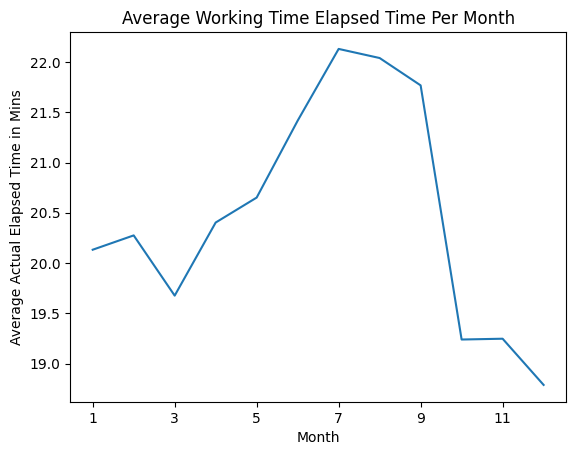

In [19]:
# plot of average actual elapsed time by month for working time only
merged.groupby('StartDate_Month')['ActualElapsedTimeInMins'].mean().plot()
plt.xlabel('Month')
plt.ylabel('Average Actual Elapsed Time in Mins')
plt.title('Average Working Time Elapsed Time Per Month')

In [20]:
# creating datasets by employees eligible 
merged_200 = merged[merged['Opportunity__r.Employees_Eligible__c'] >= 200]
merged_100 = merged[merged['Opportunity__r.Employees_Eligible__c'] <= 200]
# number of rows for 200+ lives cases
print(f"200+ lives cases count: {merged_200.shape[0]}")
print("200+ Lives Cases Working Time")
print(f"Average Actual Elapsed Time: {round(merged_200['ActualElapsedTimeInMins'].mean(), 2)}")
# number of rows for less than 200 lives cases
# print(f"<200 lives cases count: {merged_100.shape[0]}")
# print("<200 Lives Cases Service Level Agreement")
# print(f"Average Actual Elapsed Time: {round(merged_100['ActualElapsedTimeInMins'].mean(), 2)}")

200+ lives cases count: 5832
200+ Lives Cases Working Time
Average Actual Elapsed Time: 24.16


Text(0.5, 1.0, 'Actual Elapsed Time by Employee Count')

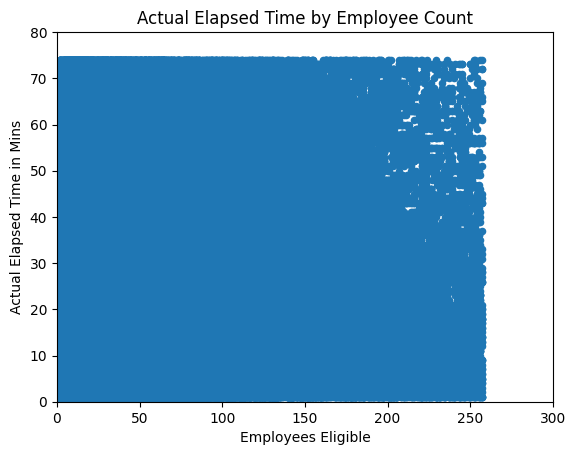

In [21]:
merged.plot.scatter('Opportunity__r.Employees_Eligible__c', 'ActualElapsedTimeInMins')
plt.xlim([0, 300])
plt.ylim([0, 80])
plt.xlabel('Employees Eligible')
plt.ylabel('Actual Elapsed Time in Mins')
plt.title('Actual Elapsed Time by Employee Count')

Text(0.5, 1.0, 'Actual Elapsed Time by Premium')

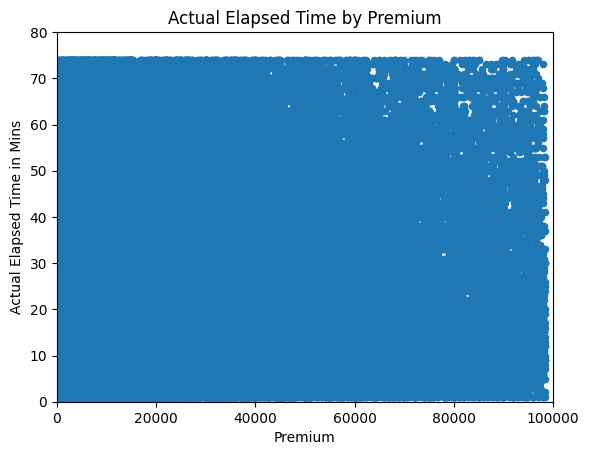

In [22]:
merged.plot.scatter('Opportunity__r.Estimated_Premium__c', 'ActualElapsedTimeInMins')
plt.xlim([0, 100000])
plt.ylim([0, 80])
plt.xlabel('Premium')
plt.ylabel('Actual Elapsed Time in Mins')
plt.title('Actual Elapsed Time by Premium')

## Modeling

In [23]:
# create dataset with columns to be used later and not to be included in model  
merged2 = merged[['OpportunityId','DistributionTerritory__c', 'Name', 'WorkOrderId', 'ParentEntityId', 'StartDate', 'CompletionDate', 'ElapsedTimeInMins',
                     'StoppedTimeInMins', 'Status', 'CreatedById', 'CreatedDate']].copy()

# dropping features with low importance and unused features
merged.drop(['Disability Income','Hospital Indemnity', 'Paid Family Medical Leave', 'Accident', 'Critical Illness', 'Group Term Life',
             'DistributionTerritory__c', 'Name', 'ParentEntityId', 'StartDate', 'CompletionDate', 'ElapsedTimeInMins',
             'StoppedTimeInMins', 'Status', 'CreatedById', 'CreatedDate','OpportunityId'], 
             axis=1, inplace=True) 
# popping opportunityid to be used later for joining
popped_id = merged.pop('WorkOrderId')

# define folds and seeds
folds = 5 
seed=0
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)

# split data into train and test
train, test = np.split(merged.sample(frac=1, random_state=seed), [int(.8*len(merged))])

# define features and target 
y_train = train['ActualElapsedTimeInMins']
X_train = train.drop('ActualElapsedTimeInMins', axis=1)
y_test = test['ActualElapsedTimeInMins']
X_test = test.drop('ActualElapsedTimeInMins', axis=1)

In [24]:
catCols = [i for i,v in enumerate(X_train.dtypes) if str(v)=='category']
#lgb model 
for train_idx, val_idx in kf.split(X_train, y_train):
    train_x, train_y = X_train.iloc[train_idx],y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    lgb_train = lgb.Dataset(train_x, label=train_y)
    lgb_val = lgb.Dataset(val_x, label=val_y, reference=lgb_train)  
    params = {
        'bagging_fraction': 0.851823068170809,
        'feature_fraction': 0.7594425277081122,
        'learning_rate': 0.16259339889160523,
        'max_bin': 54,
        'max_depth': 25,
        'min_data_in_leaf': 51,
        'min_sum_hessian_in_leaf': 45.05117639458314,
        'num_leaves': 63,
        'subsample': 0.9023447381044342,
        'boosting_type': 'dart',
        'objective': 'regression',
        'metric': 'mae',
        'is_unbalance': True}

    #run training model
    lgbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_val,
                    categorical_feature=catCols)

[LightGBM] [Warning] bagging_fraction is set=0.851823068170809, subsample=0.9023447381044342 will be ignored. Current value: bagging_fraction=0.851823068170809
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.851823068170809, subsample=0.9023447381044342 will be ignored. Current value: bagging_fraction=0.851823068170809
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 302937, number of used features: 13
[LightGBM] [Warning] bagging_fraction is set=0.851823068170809, subsample=0.9023447381044342 will be ignored. Current value: bagging_fraction=0.851823068170809
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Lig

In [25]:
# get optimal parameters 
# from sklearn.metrics import roc_auc_score, roc_curve
# from bayes_opt import BayesianOptimization

# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
#     '''function for using bayesian optimization to determine optimal training parameters for lightgbm model'''
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)

#     # parameters
#     def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
#         params = {'application':'regression', 'metric':'mae'}
#         params['learning_rate'] = max(min(learning_rate, 1), 0)
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['max_bin'] = int(round(max_depth))
#         params['min_data_in_leaf'] = int(round(min_data_in_leaf))
#         params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
#         params['subsample'] = max(min(subsample, 1), 0)
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, metrics=['rmse'])
#         return min(cv_result['valid rmse-mean'])

#     lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
#                                             'num_leaves': (24, 80),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 30),
#                                             'max_bin':(20,90),
#                                             'min_data_in_leaf': (20, 80),
#                                             'min_sum_hessian_in_leaf':(0,100),
#                                             'subsample': (0.01, 1.0)}, random_state=200)

#     #n_iter: How many steps of bayesian optimization you want to perform.
#     #init_points: How many steps of random exploration you want to perform.
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
#     mae=[]
#     for model in range(len( lgbBO.res)):
#         mae.append(lgbBO.res[model]['target'])

#     # return best parameters
#     return lgbBO.res[pd.Series(mae).idxmin()]['target'],lgbBO.res[pd.Series(mae).idxmin()]['params']

# #find optimal light gbm hyperparameters
# opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=10, n_folds=folds, random_seed=seed ,n_estimators=10000)

# #show optimal hyperparameters for light gbm training
# opt_params[1]["num_leaves"] = int(round(opt_params[1]["num_leaves"]))
# opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
# opt_params[1]['min_data_in_leaf'] = int(round(opt_params[1]['min_data_in_leaf']))
# opt_params[1]['max_bin'] = int(round(opt_params[1]['max_bin']))
# opt_params[1]['boosting_type']= 'dart'
# opt_params[1]['objective']='regression'
# opt_params[1]['metric']= 'mae'
# opt_params[1]['is_unbalance']=True
# opt_params[1]['num_class']=y_train.nunique()+1
# opt_params=opt_params[1]
# opt_params

# def custom_objective(y_true, y_pred):
#     y_pred_binary=np.round(y_pred)
#     true_positives=np.sum((y_true==1)&(y_pred_binary==1))
#     false_positives=np.sum((y_true==0)&(y_pred_binary==1))
#     true_negatives=np.sum((y_true==0)&(y_pred_binary==0))
#     false_negatives=np.sum((y_true==1)&(y_pred_binary==0))
#     custom_loss=(2*false_positives)+false_negatives
#     return 'custom_loss', custom_loss, False

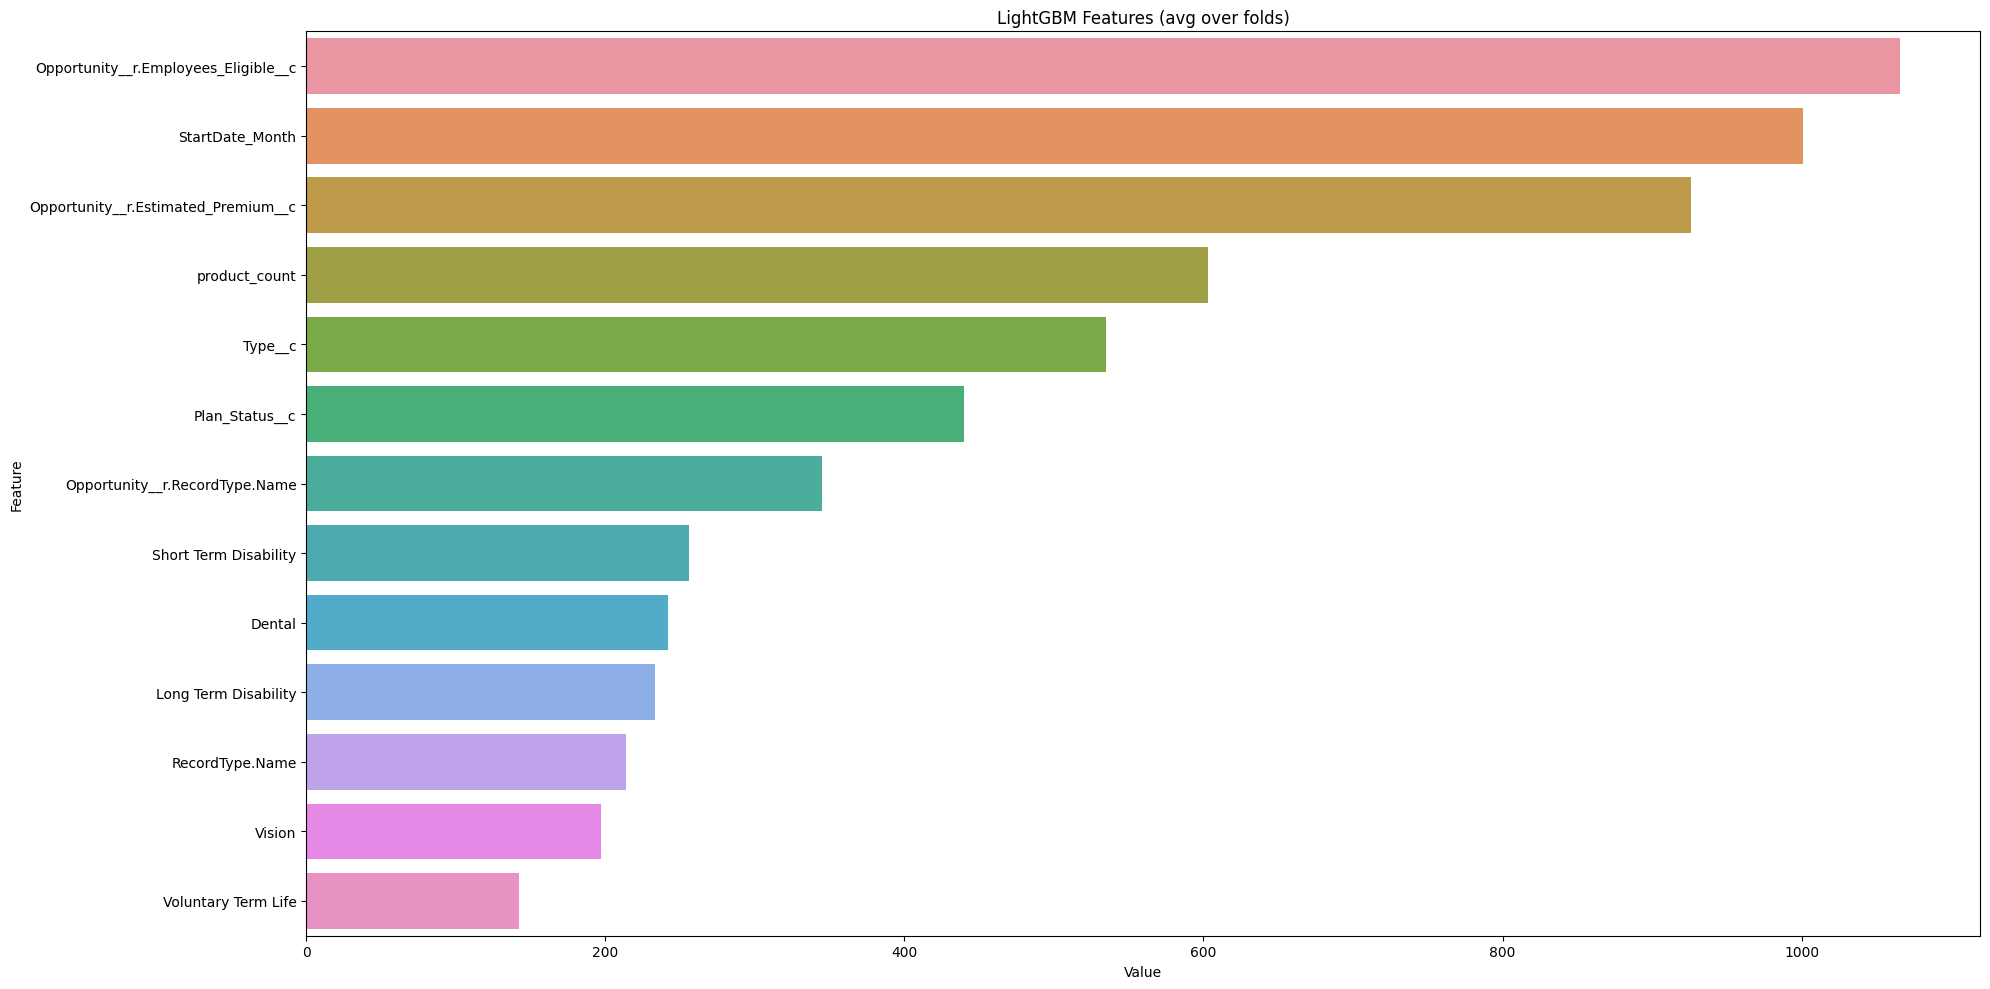

In [26]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(),X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.show()

In [27]:
preds = pd.DataFrame()
# make predictions on the test set
preds['PRED'] = np.round(abs(lgbm.predict(X_test)))
preds['ACTUAL'] = y_test.reset_index(drop=True)
preds['ERROR']=np.round(abs((preds['PRED']-preds['ACTUAL'])),0)

# get stats on errors 
print(f"Average Error: {round(preds['ERROR'].mean(), 2)} minutes")
print(f"Median Error: {round(preds['ERROR'].median(), 2)} minutes")
print(f"Min Error: {round(preds['ERROR'].min(), 2)} minutes")
print(f"Max Error: {round(preds['ERROR'].max(), 2)} minutes")

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(preds['ACTUAL'], preds['ERROR'], squared=False)
print(f"RMSE: {round(rmse, 2)} minutes")

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(preds['ACTUAL'], preds['PRED'])
print(f"MAE: {round(mae, 2)} minutes")

Average Error: 10.16 minutes
Median Error: 7.0 minutes
Min Error: 0.0 minutes
Max Error: 65.0 minutes
RMSE: 16.57 minutes
MAE: 10.16 minutes


In [28]:
# flag errors that are over the mean minute error of 10 minutes
preds['flag'] = preds['ERROR'].apply(lambda x: 'False' if x <= 10 else 'True')

# retrieve popped id in X_test and merge with predictions
X_test_df = X_test.join(popped_id, how='inner').reset_index()
preds_df = pd.concat([X_test_df, preds], axis=1, join='inner')
#preds_df[preds_df['flag']=='True'].sort_values(by='ERROR', ascending=False)

# merge predictions with unused columns 
export_data = pd.merge(preds_df, merged2, on='WorkOrderId', how='left')

In [29]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(lgbm)
# Calculate Shap values
shap_values = explainer.shap_values(X_test, y_test)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


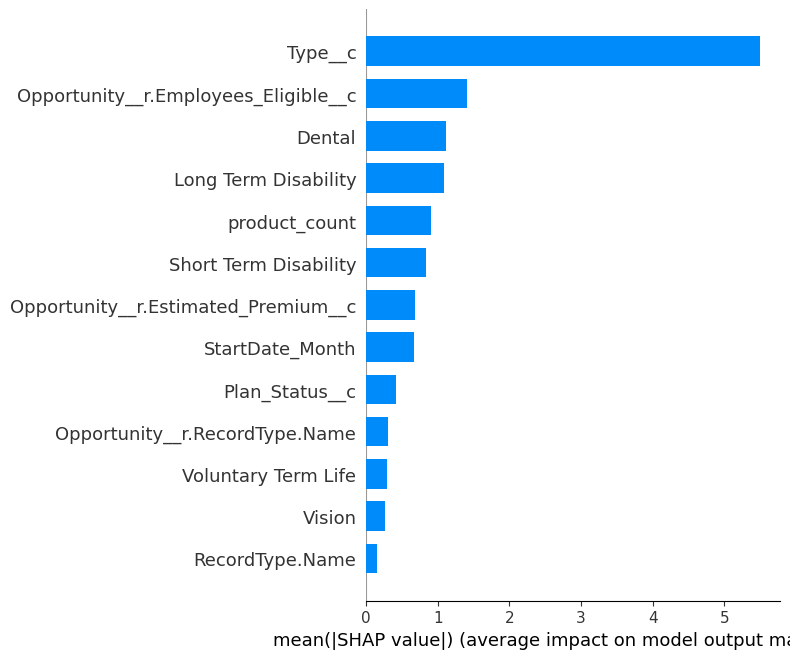

In [30]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

In [31]:
# get shap values into dataframe 
def shapley_feature_ranking(shap_values, X_test):
    feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
    return pd.DataFrame(
        {            "features": [X_test.columns[i] for i in feature_order][::-1],
            "importance": [
                np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
            ][::-1],
        }
    )
shap_df = shapley_feature_ranking(shap_values, X_test)

# merge data with the broker
sec_data = pd.merge(export_data, broker_df, on='OpportunityId', how='left')

# export to csv for power bi report
#sec_data.to_csv(r'C:/Users/H008906/OneDrive - Principal Financial Group/SEC/sec_data.csv', index=False)
#shap_df.to_csv(r'C:/Users/H008906/OneDrive - Principal Financial Group/SEC/sec_shap_data.csv', index=False)